In [13]:
# Step 1 — mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Step 2 — imports and device
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from time import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [15]:
# Step 3 — find the folders (one-time)
def find_folder(folder_name, start="/content/drive/MyDrive"):
    for root, dirs, files in os.walk(start):
        if folder_name in dirs:
            return os.path.join(root, folder_name)
    return None

images_path = find_folder("images_tensor")
density_path = find_folder("density_tensor")

print("images_path:", images_path)
print("density_path:", density_path)

if images_path is None or density_path is None:
    raise Exception("Could not find images_tensor or density_tensor. Check Drive.")


images_path: /content/drive/MyDrive/deepvision/processed/images_tensor
density_path: /content/drive/MyDrive/deepvision/processed/density_tensor


In [16]:
# Step 4 — dataset class and quick check
IMG_DIR = images_path
GT_DIR  = density_path

class CrowdDataset(Dataset):
    def __init__(self, img_folder, gt_folder):
        self.img_folder = img_folder
        self.gt_folder  = gt_folder
        self.files = sorted([f for f in os.listdir(self.img_folder) if f.endswith(".pt")])
        if len(self.files) == 0:
            raise ValueError("No .pt files found in image folder.")
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        name = self.files[idx]
        img = torch.load(os.path.join(self.img_folder, name)).float()   # expecting [3,H,W]
        gt  = torch.load(os.path.join(self.gt_folder,  name)).float()   # expecting [H2,W2] or [1,H2,W2]
        # ensure GT is 1xHxW
        if gt.dim() == 2:
            gt = gt.unsqueeze(0)
        return img, gt

dataset = CrowdDataset(IMG_DIR, GT_DIR)
print("Total samples:", len(dataset))

# preview shapes
img, gt = dataset[0]
print("sample img shape:", tuple(img.shape))
print("sample gt shape:", tuple(gt.shape))


Total samples: 300
sample img shape: (3, 512, 512)
sample gt shape: (1, 64, 64)


In [17]:
# Step 5 — CSRNet model (small/simple variant used earlier)
class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()
        self.frontend = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.backend = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 1, 1),
        )
    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x

model = CSRNet().to(device)
print("Model created.")


Model created.


In [19]:
# Step 6 — training loop (minimal). Tweak hyperparams as needed.
epochs = 100        # change to more epochs if you want
batch_size = 4
lr = 1e-4

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses = []
start_time = time()
model.train()
for epoch in range(1, epochs+1):
    epoch_loss = 0.0
    count = 0
    for imgs, gts in loader:
        imgs = imgs.to(device)            # [B,3,H,W]
        gts  = gts.to(device)             # [B,1,H2,W2]
        preds = model(imgs)              # [B,1,Hp,Wp]

        # If pred and gt sizes differ, resize pred to gt (or vice versa)
        if preds.shape[2:] != gts.shape[2:]:
            preds_resized = F.interpolate(preds, size=gts.shape[2:], mode='bilinear', align_corners=False)
        else:
            preds_resized = preds

        loss = criterion(preds_resized, gts)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        count += 1

    avg_loss = epoch_loss / (count if count>0 else 1)
    train_losses.append(avg_loss)
    elapsed = time() - start_time
    print(f"Epoch {epoch}/{epochs}  Loss: {avg_loss:.6f}  Time elapsed: {elapsed/60:.2f} min")

# Save checkpoint to Drive
save_path = "/content/drive/MyDrive/deepvision/csrnet_trained.pth"
torch.save(model.state_dict(), save_path)
print("Model saved to:", save_path)


Epoch 1/100  Loss: 0.018156  Time elapsed: 0.13 min
Epoch 2/100  Loss: 0.018431  Time elapsed: 0.24 min
Epoch 3/100  Loss: 0.018098  Time elapsed: 0.36 min
Epoch 4/100  Loss: 0.018132  Time elapsed: 0.48 min
Epoch 5/100  Loss: 0.018097  Time elapsed: 0.60 min
Epoch 6/100  Loss: 0.018234  Time elapsed: 0.72 min
Epoch 7/100  Loss: 0.018025  Time elapsed: 0.85 min
Epoch 8/100  Loss: 0.018085  Time elapsed: 0.97 min
Epoch 9/100  Loss: 0.018168  Time elapsed: 1.09 min
Epoch 10/100  Loss: 0.018013  Time elapsed: 1.22 min
Epoch 11/100  Loss: 0.018009  Time elapsed: 1.34 min
Epoch 12/100  Loss: 0.018091  Time elapsed: 1.47 min
Epoch 13/100  Loss: 0.017995  Time elapsed: 1.58 min
Epoch 14/100  Loss: 0.017961  Time elapsed: 1.71 min
Epoch 15/100  Loss: 0.018189  Time elapsed: 1.83 min
Epoch 16/100  Loss: 0.018065  Time elapsed: 1.95 min
Epoch 17/100  Loss: 0.018033  Time elapsed: 2.07 min
Epoch 18/100  Loss: 0.017966  Time elapsed: 2.20 min
Epoch 19/100  Loss: 0.017887  Time elapsed: 2.31 min
Ep

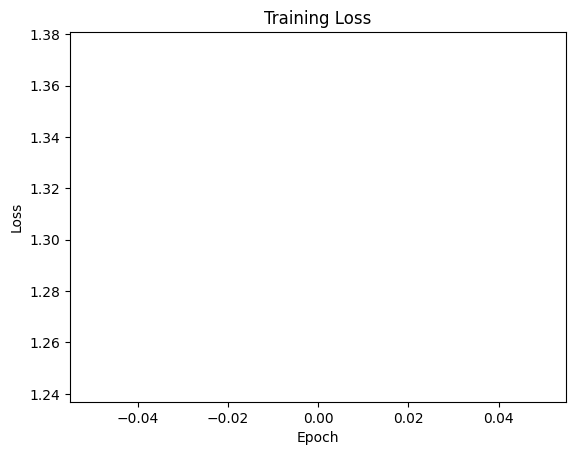

<Figure size 640x480 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
plt.plot(epoch_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.savefig("/content/drive/MyDrive/deepvision/training_loss.png")



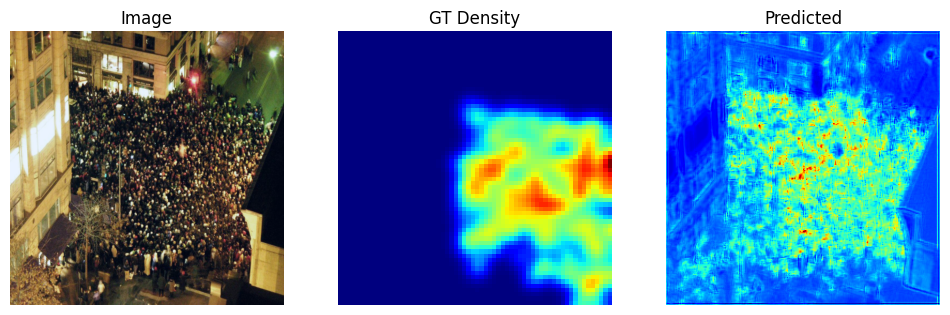

In [24]:
i = 50   # any index
img, gt = dataset[i]
img_gpu = img.unsqueeze(0).to(device)

pred = model(img_gpu).detach().cpu().squeeze(0).squeeze(0)

plt.figure(figsize=(12,4))
# Normalize image for display to prevent clipping warning
img_display = img.squeeze().permute(1,2,0)
img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
plt.subplot(1,3,1); plt.imshow(img_display); plt.title("Image"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(gt.squeeze(), cmap='jet'); plt.title("GT Density"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(pred, cmap='jet'); plt.title("Predicted"); plt.axis("off")
plt.show()

In [25]:
save_path = "/content/drive/MyDrive/deepvision/csrnet_trained.pth"
torch.save(model.state_dict(), save_path)
print("Model saved to:", save_path)


Model saved to: /content/drive/MyDrive/deepvision/csrnet_trained.pth
